In [135]:
import control as ctrl
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import sympy as sp

In [136]:
plt.style.use(plt.style.available[9])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [137]:
class DeepNetwork(torch.nn.Module):
    def __init__(self, input_dim=8, hidden_dims=[128, 128, 128], num_classes=5):
        super(DeepNetwork, self).__init__()
        layers = []
        dims = [input_dim] + hidden_dims
        
        # Build the hidden layers
        for i in range(len(dims) - 1):
            layers.append(torch.nn.Linear(dims[i], dims[i + 1]))
            layers.append(torch.nn.ReLU())
        
        # Output layer
        layers.append(torch.nn.Linear(dims[-1], num_classes))
        
        # Sequentially stack the layers
        self.model = torch.nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [138]:
numerator = [40]
denominator = [1, 1]
H_s = ctrl.tf(numerator,denominator)
H_s

TransferFunction(array([40]), array([1, 1]))

In [ ]:
# Example white noise input signal
torch.manual_seed(42)
input_signal = np.random.rand(500)
time = np.arange(0, 10, 0.02)

# Generate system response using control library
T, y_out = ctrl.forced_response(H_s, T=time, U=input_signal)

print(f'input_signal shape: {input_signal.shape}')
print(f'ouput signal shape: {y_out.shape}')


input_signal shape: (500,)
ouput signal shape: (500,)


array([ 0.        ,  0.267503  ,  0.45397322,  0.74824996,  1.14144301,
        1.51754125,  2.10305783,  2.46101665,  2.54190837,  2.66613374,
        3.01549101,  3.50877148,  4.00520884,  4.29316362,  4.3047909 ,
        4.63728497,  5.0538638 ,  5.38483033,  5.57773769,  5.69942228,
        6.02159261,  6.44870205,  6.82497994,  7.12657104,  7.47566878,
        7.70942583,  7.90941689,  8.21370168,  8.44071686,  8.47443607,
        8.47273726,  8.45647987,  8.65622166,  8.96350072,  9.29822083,
        9.85784856, 10.03442747, 10.11107201, 10.4414414 , 10.8078353 ,
       11.04948075, 11.16015531, 11.1751151 , 11.32264281, 11.62449391,
       11.61475391, 11.73718248, 12.06712622, 12.1471819 , 12.09492264,
       12.22263242, 12.25585962, 12.32916239, 12.62069572, 12.80122142,
       12.78057052, 12.60977018, 12.5524885 , 12.80194355, 12.93916375,
       12.96406221, 13.10622501, 13.0954621 , 13.27534062, 13.58236877,
       13.56564933, 13.65345046, 13.94841155, 14.28852944, 14.78

In [140]:
X = torch.from_numpy(y_out).reshape(-1, 1).to(device).float()
y = torch.from_numpy(input_signal).reshape(-1, 1).to(device).float()

model = DeepNetwork(input_dim=X.shape[1], hidden_dims=[64,4], num_classes=1).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10000
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(X)
    loss = criterion(outputs, y)
    loss.backward()
    optimizer.step()
    if epoch %5000 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item()}")

Epoch 0, Loss: 0.32306230068206787
Epoch 5000, Loss: 0.08339947462081909


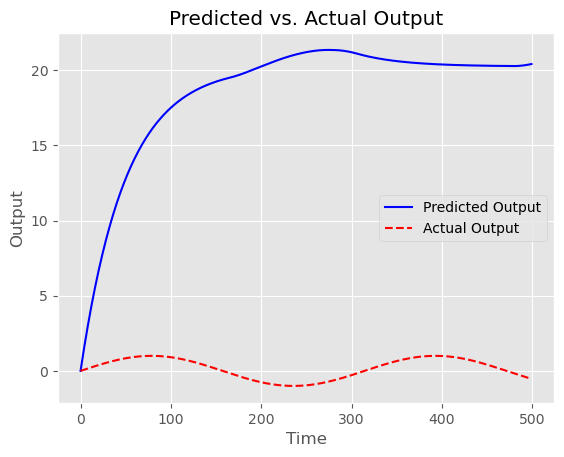

In [141]:
input_test = np.sin(time)
out = model(torch.from_numpy(input_test).reshape(-1,1).to(device).float())
T, y_test = ctrl.forced_response(H_s, T=time, U=out.t().detach().cpu().numpy())

plt.plot(y_test, label="Predicted Output", color="blue")
plt.plot(input_test, label="Actual Output", color="red", linestyle="--")
plt.xlabel("Time")
plt.ylabel("Output")
plt.legend()
plt.title("Predicted vs. Actual Output")
plt.show()